# Probability distribution using Oscilloscope

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Load the CSV file (replace with your actual file path)
file_path = 'tek0006ALL.csv'
df = pd.read_csv(file_path, skiprows=20)

# Rename columns
#df.columns = ['TIME', 'CH2', 'CH3', 'CH4']
df.columns = ['TIME', 'CH4']

# Extract time and signal data (assuming CH4 as example)
time = df['TIME']
ch4 = df['CH4']

# Define the interval width
interval_width = 5.039999999983946e-08  # Time interval width

# Define photon ranges (in volts)
photon_ranges = {
    '1 Photon': (-0.940, -0.600),
    '2 Photon': (-1.220, -0.941),
    '3 Photon': (-1.5, -1.221),
    '4 Photon': (-1.97, -1.501),
}

# Classify peaks
classified_peaks = {'0 Photon': [],'1 Photon': [], '2 Photon': [], '3 Photon': [], '4 Photon': []}

# Create bins based on the interval width
time_min, time_max = np.min(time), np.max(time)
bins = np.arange(time_min, time_max, interval_width)

# Find peaks in the signal
peaks, _ = find_peaks(-ch4, height=0.35)

# Initialize lists to store results
classified_intervals = []

# Iterate over each interval
for i in range(len(bins) - 1):
    # Define the start and end of the interval
    start, end = bins[i], bins[i + 1]

    # Get indices of peaks within this interval
    peaks_in_interval = peaks[(time[peaks] >= start) & (time[peaks] < end)]

    # Initialize classification for the interval
    interval_classification = {'Interval Start': start, 'Interval End': end, 'Classification': '0 Photons'}

    # Check if there are peaks in the interval
    if len(peaks_in_interval) > 0:
        # Find the highest peak in the interval
        max_peak_idx = peaks_in_interval[np.argmax(ch4.iloc[peaks_in_interval])]
        max_amplitude = ch4.iloc[max_peak_idx]

        # Classify the peak based on photon ranges
        for photon, (lower, upper) in photon_ranges.items():
            if lower <= max_amplitude <= upper:
                interval_classification['Classification'] = photon
                classified_peaks[photon].append(max_peak_idx)
                break  # Stop checking after classification
    else:
        # If no peaks, classify as 0 photons
        interval_classification['Classification'] = '0 Photons'
        classified_peaks['0 Photon'].append(0)

    # Append the interval classification
    classified_intervals.append(interval_classification)


# Convert results to a DataFrame for better visualization
classified_intervals_df = pd.DataFrame(classified_intervals)

# Display results
print(classified_intervals_df)

# Optional: Plot the signal with classified peaks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, ch4, color='blue', alpha=0.7, label='Signal')


# Plot peaks for each photon category
colors = ['gray', 'green', 'orange', 'red', 'purple']
for i, (photon, peak_indices) in enumerate(classified_peaks.items()):
    plt.scatter(time.iloc[peak_indices], ch4.iloc[peak_indices],
                label=f'{photon} Peaks', color=colors[i])

# Plot settings
plt.title('Classified Peaks in Intervals', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

       Interval Start  Interval End Classification
0           -0.002094     -0.002094      0 Photons
1           -0.002094     -0.002094      0 Photons
2           -0.002094     -0.002094       1 Photon
3           -0.002094     -0.002094       2 Photon
4           -0.002094     -0.002094       1 Photon
...               ...           ...            ...
79360        0.001905      0.001905      0 Photons
79361        0.001905      0.001905       1 Photon
79362        0.001905      0.001906      0 Photons
79363        0.001906      0.001906       3 Photon
79364        0.001906      0.001906       2 Photon

[79365 rows x 3 columns]


C:\Users\dalop\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


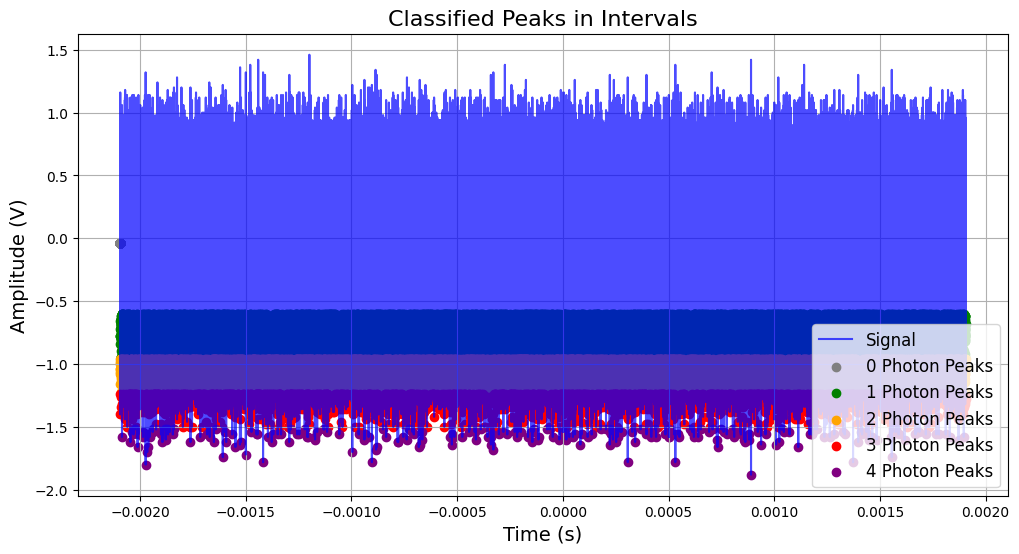

In [162]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Load the CSV file (replace with your actual file path)
file_path = 'tek0012ALL.csv'
df = pd.read_csv(file_path, skiprows=20)

# Rename columns
#df.columns = ['TIME', 'CH2', 'CH3', 'CH4']
df.columns = ['TIME', 'CH4']

# Convert CH4 column to numeric, coercing errors (non-numeric values will be replaced with NaN)
df['CH4'] = pd.to_numeric(df['CH4'], errors='coerce')

# Drop rows with NaN values in CH4
df = df.dropna(subset=['CH4'])

# Extract time and signal data again after cleaning
time = df['TIME']
ch4 = df['CH4']

# Define the interval width
interval_width = 5.039999999983946e-08  # Time interval width

# Define photon ranges (in volts)
photon_ranges = {
    '1 Photon': (-0.940, -0.600),
    '2 Photon': (-1.220, -0.941),
    '3 Photon': (-1.5, -1.221),
    '4 Photon': (-1.97, -1.501),
}


# Classify peaks
classified_peaks = {'0 Photon': [], '1 Photon': [], '2 Photon': [], '3 Photon': [], '4 Photon': []}

# Create bins based on the interval width
time_min, time_max = np.min(time), np.max(time)
bins = np.arange(time_min, time_max, interval_width)

# Find peaks in the signal
peaks, _ = find_peaks(-ch4, height=0.35)

# Initialize lists to store results
classified_intervals = []

# Iterate over each interval
for i in range(len(bins) - 1):
    # Define the start and end of the interval
    start, end = bins[i], bins[i + 1]

    # Get indices of peaks within this interval
    peaks_in_interval = peaks[(time.iloc[peaks] >= start) & (time.iloc[peaks] < end)]

    # Initialize classification for the interval
    interval_classification = {'Interval Start': start, 'Interval End': end, 'Classification': '0 Photons'}

    # Check if there are peaks in the interval
    if len(peaks_in_interval) > 0:
        # Find the highest peak in the interval
        max_peak_idx = peaks_in_interval[np.argmax(ch4.iloc[peaks_in_interval])]
        max_amplitude = ch4.iloc[max_peak_idx]

        # Classify the peak based on photon ranges
        for photon, (lower, upper) in photon_ranges.items():
            if lower <= max_amplitude <= upper:
                interval_classification['Classification'] = photon
                classified_peaks[photon].append(max_peak_idx)
                break  # Stop checking after classification
    else:
        # If no peaks, classify as 0 photons
        interval_classification['Classification'] = '0 Photons'
        classified_peaks['0 Photon'].append(0)

    # Append the interval classification
    classified_intervals.append(interval_classification)

# Convert results to a DataFrame for better visualization
classified_intervals_df = pd.DataFrame(classified_intervals)

# Display results
print(classified_intervals_df)

# Optional: Plot the signal with classified peaks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, ch4, color='blue', alpha=0.7, label='Signal')

# Plot peaks for each photon category
colors = ['gray', 'green', 'orange', 'red', 'purple']
for i, (photon, peak_indices) in enumerate(classified_peaks.items()):
    plt.scatter(time.iloc[peak_indices], ch4.iloc[peak_indices],
                label=f'{photon} Peaks', color=colors[i])

# Plot settings
plt.title('Classified Peaks in Intervals', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


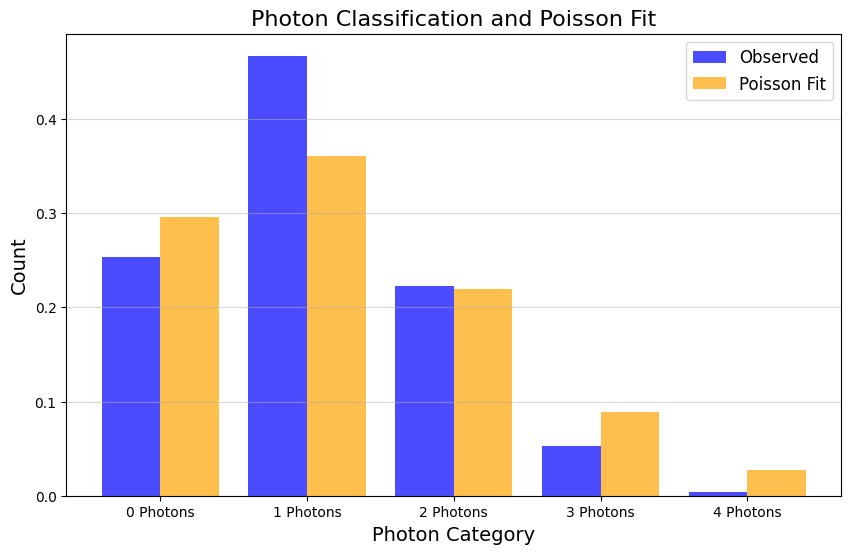

Fitted lambda (mean photon count): 1.217


In [163]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

# Generate histogram data
photon_counts = {photon: len(indices) for photon, indices in classified_peaks.items()}

# Convert the dictionary to numeric values
categories = np.array([0, 1, 2, 3, 4])  # Numeric photon categories
counts = np.array(list(photon_counts.values())) # Observed counts
total_count = np.sum(counts)  # Total observed count
probabilities = counts/total_count

# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, probabilities , p0=[1])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, probabilities , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title('Photon Classification and Poisson Fit', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")


# Getting the $P$ matrix

In [174]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import factorial


P = np.array([
    [1, 0.076, 0.0063, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.924, 0.507, 0.260, 0.135, 0.0716, 0.0383, 0.0207, 0.0113, 0.0062],
    [0, 0, 0.487, 0.647, 0.6728, 0.6482, 0.6067, 0.5596, 0.5139, 0.4712],
    [0, 0, 0, 0.0919, 0.1858, 0.2645, 0.3275, 0.3777, 0.4177, 0.4498],
    [0, 0, 0, 0, 0.00588, 0.0157, 0.0281, 0.0419, 0.0569, 0.0767]
])

def poisson_distribution(P, tau, wavelength, max_m, duty):
    """
    Generate a Poisson distribution array.

    Parameters:
    - P: Laser power (in watts).
    - tau: Pulse duration (in seconds).
    - wavelength: Laser wavelength (in meters).
    - max_m: Maximum number of photons to compute in the distribution.

    Returns:
    - Array of probabilities for photon numbers 0 to max_m.
    """
    # Constants
    h = 6.626e-34  # Planck's constant (J·s)
    c = 3e8        # Speed of light (m/s)

    # Calculate the frequency of the laser
    nu = c / wavelength

    # Calculate the mean photon number (mu)
    P_peak = P/duty
    mu = (P_peak * tau) / (h * nu)
    # Generate the Poisson distribution
    m_values = np.arange(0, max_m)  # Photon numbers from 0 to max_m
    S_m = (mu ** m_values / factorial(m_values)) * np.exp(-mu)

    return S_m

def euclidean_norm(P_flat, Q, S, n, m):
    """
    Compute the Euclidean norm ||Q - PS||_2.

    Parameters:
    - P_flat: Flattened lower triangular matrix (optimization variable).
    - Q: Observed statistics vector (numpy array).
    - S: Input statistics vector (numpy array).
    - n: Number of pixels.
    - m: Maximum number of photons.

    Returns:
    - Euclidean norm ||Q - PS||_2.
    """
    # Reconstruct the upper triangular P matrix
    P_z = np.zeros((n, m))
    triu_indices = np.triu_indices(n, 0, m)

    # Remove P[0][0] from indices
    exclude_index = (triu_indices[0] == 0) & (triu_indices[1] == 0)
    triu_indices = (
        triu_indices[0][~exclude_index],
        triu_indices[1][~exclude_index]
    )

    P_z[triu_indices] = P_flat

    # Enforce P[0][0] = 1
    P_z[0, 0] = 1

    # Compute PS
    PS = np.dot(P_z, S)
    
    # Compute the Euclidean norm
    norm = np.linalg.norm(Q - PS, ord=2)
    return norm

def optimize_P(Q, S, n, m):
    """
    Optimize the detector response matrix P to minimize ||Q - PS||_2.

    Parameters:
    - Q: Observed statistics vector (numpy array).
    - S: Input statistics vector (numpy array).
    - n: Number of pixels.
    - m: Maximum number of photons.

    Returns:
    - Optimized detector response matrix P.
    """
    # Extract indices for the upper triangular part of the matrix
    triu_indices = np.triu_indices(n, 0, m)

    # Remove P[0][0] from indices
    exclude_index = (triu_indices[0] == 0) & (triu_indices[1] == 0)
    triu_indices = (
        triu_indices[0][~exclude_index],
        triu_indices[1][~exclude_index]
    )
    
    # Initial guess for P (flat array of upper triangular elements)
    P_initial = P[triu_indices]
    
    # Adjust bounds to match the size of the upper triangular part
    num_params = len(P_initial)
    bounds = [(0, 1) for _ in range(num_params)]
    
    # Optimization
    result = minimize(
        euclidean_norm, P_initial, args=(Q, S, n, m),
        method='L-BFGS-B', bounds=bounds
    )
    
    # Reconstruct the optimized upper triangular P matrix
    P_optimized = np.zeros((n, m))
    P_optimized[triu_indices] = result.x

    # Enforce P[0][0] = 1
    P_optimized[0, 0] = 1

    return P_optimized


# Example usage
p = 3.05e-12  # Laser average power in watts 
duty = 0.000006 # Duty cicle of the laser pulse
tau = 0.4e-12  # Pulse duration in seconds 
wavelength = 1310e-9  # Laser wavelength in meters

# Example usage
n = 5  # Number of pixels (0 to 3 clicks)
m = 10  # Maximum number of photons considered (0 to 4 photons)

# Observed statistics Q (example)
Q = probabilities

# Input statistics S (Poisson distribution with mean photon number)
S = poisson_distribution(p, tau, wavelength, m, duty)
print("Poisson Distribution:", S)

# Optimize P
P_optimized = optimize_P(Q, S, n, m)
print("Optimized P:\n", P_optimized)


output_file = f"./optimized_P/optimized_P_matrix_{file_path}.csv"  # Define the file name
np.savetxt(output_file, P_optimized, delimiter=',', fmt='%0.6f')  # Save P_optimized to CSV
print(f"Optimized P matrix saved to {output_file}")
#triu_indices = np.triu_indices(5, 0, 10)
#p_T = P[triu_indices]

#eu = euclidean_norm(p_T.flatten(), Q, S, n, m)
#print(eu)


Poisson Distribution: [2.61843737e-01 3.50872539e-01 2.35085896e-01 1.05005612e-01
 3.51770736e-02 9.42750762e-03 2.10548830e-03 4.03052836e-04
 6.75117217e-05 1.00518006e-05]
Optimized P:
 [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.9073359  0.49583513 0.25501307 0.13332938 0.07115227
  0.03820001 0.02068086 0.01129679 0.00619952]
 [0.         0.         0.51787184 0.66078957 0.67741954 0.64943805
  0.6069765  0.55965293 0.51390887 0.47120132]
 [0.         0.         0.         0.37306609 0.27999117 0.28974338
  0.33313772 0.37877923 0.41788077 0.44982692]
 [0.         0.         0.         0.         0.10153982 0.04133697
  0.03382562 0.04299605 0.05708359 0.07672733]]
Optimized P matrix saved to ./optimized_P/optimized_P_matrix_tek0012ALL.csv.csv


# Reconstruction of the probability distribution

Truncated and Non-Negative S (size 5): [0.19792094 0.38794093 0.24709916 0.11685042 0.04146501]
Figure saved to ./optimized_P/photon_classification_poisson_fit_tek0012ALL.csv.png


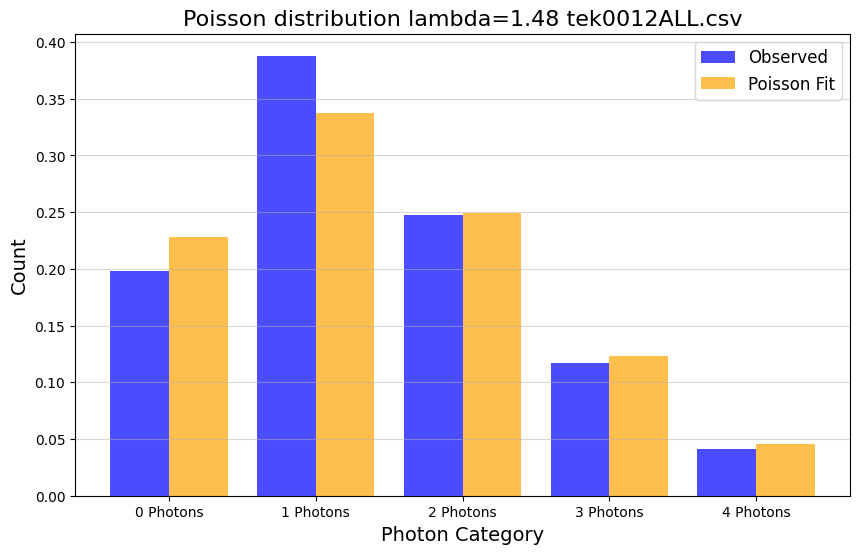

Fitted lambda (mean photon count): 1.479


In [ ]:
from scipy.optimize import nnls

def truncate_and_nnls(P, Q, k):
    """
    Truncate P to a k x k matrix and solve for S using non-negative least squares.

    Parameters:
    - P: Transition matrix (2D numpy array).
    - Q: Observed statistics vector (1D numpy array).
    - k: Size to truncate P to (integer).

    Returns:
    - Non-negative solution S for the truncated system.
    """
    # Truncate P to a k x k matrix
    P_truncated = P[:k, :k]
    Q_truncated = Q[:k]

    # Solve using NNLS
    S_truncated, _ = nnls(P_truncated, Q_truncated)

    return S_truncated

# Example usage
k = 5


#S_truncated_nnls = truncate_and_nnls(avg_p_matrix, probabilities, k)

S_truncated_nnls = truncate_and_nnls(P_optimized, probabilities, k)

print(f"Truncated and Non-Negative S (size {k}):", S_truncated_nnls)


# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, S_truncated_nnls , p0=[0.3])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, S_truncated_nnls , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title(f'Poisson distribution lambda={fitted_lambda:.2f} {file_path}', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)


# Save the figure
output_figure_path = f"./optimized_P/photon_classification_poisson_fit_{file_path}.png"  # Define the file name for saving the figure
plt.savefig(output_figure_path, dpi=300, bbox_inches='tight')  # Save with high resolution and tight layout
print(f"Figure saved to {output_figure_path}")

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")




In [179]:
import numpy as np
import os

# Path to the folder containing the CSV files
csv_folder = "optimized_P"  # Replace with your actual folder path

# List all CSV files in the folder
csv_files = [os.path.join(csv_folder, file) for file in os.listdir(csv_folder) if file.endswith('.csv')]

# Ensure there are files to process
if not csv_files:
    print("No CSV files found in the specified folder.")
else:
    # Initialize a list to store all P matrices
    matrices = []

    # Load each matrix from the provided CSV files
    for file in csv_files:
        matrix = np.loadtxt(file, delimiter=',')  # Read the matrix from the file
        matrices.append(matrix)

    # Convert the list of matrices into a 3D numpy array
    stacked_matrices = np.stack(matrices)

    # Calculate the average along the first axis
    avg_p_matrix = np.average(stacked_matrices, axis=0)
    std_p_matrix = np.std(stacked_matrices, axis=0)

    # Save the average P matrix to a new CSV file
    output_file = os.path.join(csv_folder, "average_P_matrix.csv")
    np.savetxt(output_file, avg_p_matrix, delimiter=',', fmt='%0.6f')
    output_file = os.path.join(csv_folder, "std_P_matrix.csv")
    np.savetxt(output_file, std_p_matrix, delimiter=',', fmt='%0.6f')
    print(f"Average P matrix saved to {output_file}")

    # Print the average P matrix
    print("Average P matrix:\n", avg_p_matrix)


Average P matrix saved to optimized_P\std_P_matrix.csv
Average P matrix:
 [[9.000000e-01 9.386330e-02 9.419350e-02 3.756960e-02 2.359900e-03
  4.045000e-04 8.940000e-05 1.780000e-05 3.100000e-06 5.000000e-07]
 [0.000000e+00 7.665742e-01 4.172385e-01 2.147595e-01 1.186767e-01
  6.385380e-02 3.434160e-02 1.860500e-02 1.016570e-02 5.579400e-03]
 [0.000000e+00 0.000000e+00 4.392665e-01 5.907594e-01 6.086598e-01
  5.842237e-01 5.462173e-01 5.036756e-01 4.625158e-01 4.240807e-01]
 [0.000000e+00 0.000000e+00 0.000000e+00 3.269657e-01 2.503371e-01
  2.607092e-01 2.999048e-01 3.409363e-01 3.761024e-01 4.048461e-01]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 9.130930e-02
  3.755350e-02 3.061340e-02 3.874850e-02 5.138760e-02 6.905700e-02]]
